In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore') 

# Data Preprocessing

In [154]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

columns = [
    "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", 
    "RAD", "TAX", "PTRATIO", "B", "LSTAT"
]
df = pd.DataFrame(data, columns=columns)

In [155]:
df.shape

(506, 13)

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


In [157]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [158]:
df=df.dropna()
df.shape

(506, 13)

# K-Means Clustering

In [160]:
# 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# KMeans 聚类并 Silhouette 分析
scores = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    scores.append(score)
    print(f"Silhouette score for k={k}: {score:.4f}")

Silhouette score for k=2: 0.3601
Silhouette score for k=3: 0.2448
Silhouette score for k=4: 0.2275
Silhouette score for k=5: 0.2389
Silhouette score for k=6: 0.2291


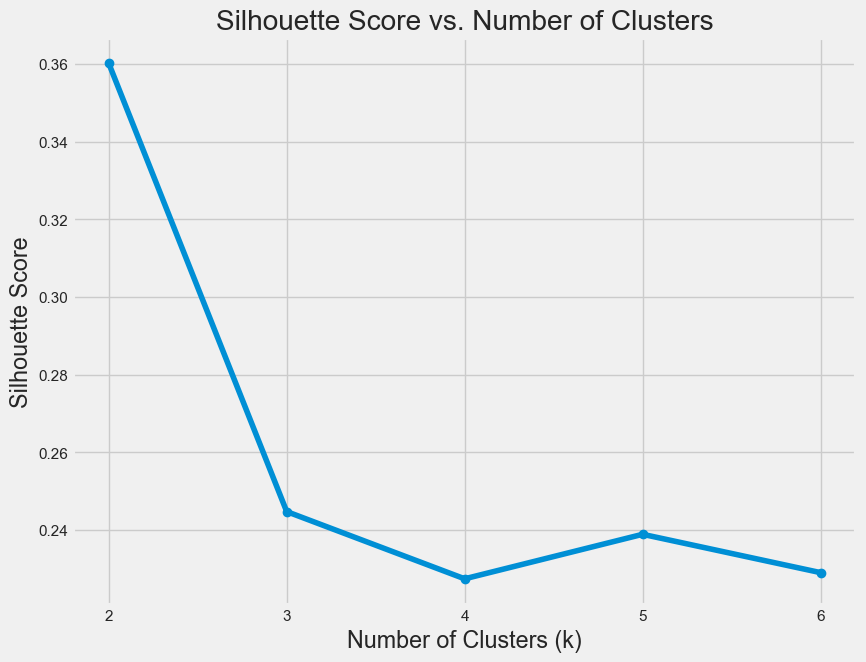

In [187]:
# 可视化 silhouette 分数与聚类数 k 的关系
plt.figure(figsize=(9, 7))
plt.plot(range(2, 7), scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, 7))
plt.grid(True)
plt.savefig('D:/PythonProject/Pictures/boston_k.png', dpi = 300)
plt.show()


In [167]:
# 选出最佳 k（Silhouette 最大值）
best_k = np.argmax(scores) + 2  # 因为从 k=2 开始
print("Best k:", best_k)

# 聚类
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)
df['cluster'] = labels


Best k: 2


In [168]:
# 每个聚类的均值（反标准化前）
cluster_means = df.groupby('cluster').mean()

# KMeans 得到的质心（在标准化空间中）
centroids_scaled = kmeans.cluster_centers_

# 将质心还原为原始尺度
centroids_original = scaler.inverse_transform(centroids_scaled)
centroids_df = pd.DataFrame(centroids_original, columns=columns)

print("Cluster Means:\n", cluster_means[columns])
print("\nCentroid Coordinates:\n", centroids_df)


Cluster Means:
              CRIM         ZN      INDUS      CHAS       NOX        RM  \
cluster                                                                 
0        0.261172  17.477204   6.885046  0.069909  0.487011  6.455422   
1        9.844730   0.000000  19.039718  0.067797  0.680503  5.967181   

               AGE       DIS        RAD         TAX    PTRATIO           B  \
cluster                                                                      
0        56.339210  4.756868   4.471125  301.917933  17.837386  386.447872   
1        91.318079  2.007242  18.988701  605.858757  19.604520  301.331695   

             LSTAT  
cluster             
0         9.468298  
1        18.572768  

Centroid Coordinates:
        CRIM            ZN      INDUS      CHAS       NOX        RM        AGE  \
0  0.261172  1.747720e+01   6.885046  0.069909  0.487011  6.455422  56.339210   
1  9.844730  1.243450e-14  19.039718  0.067797  0.680503  5.967181  91.318079   

        DIS        RAD    

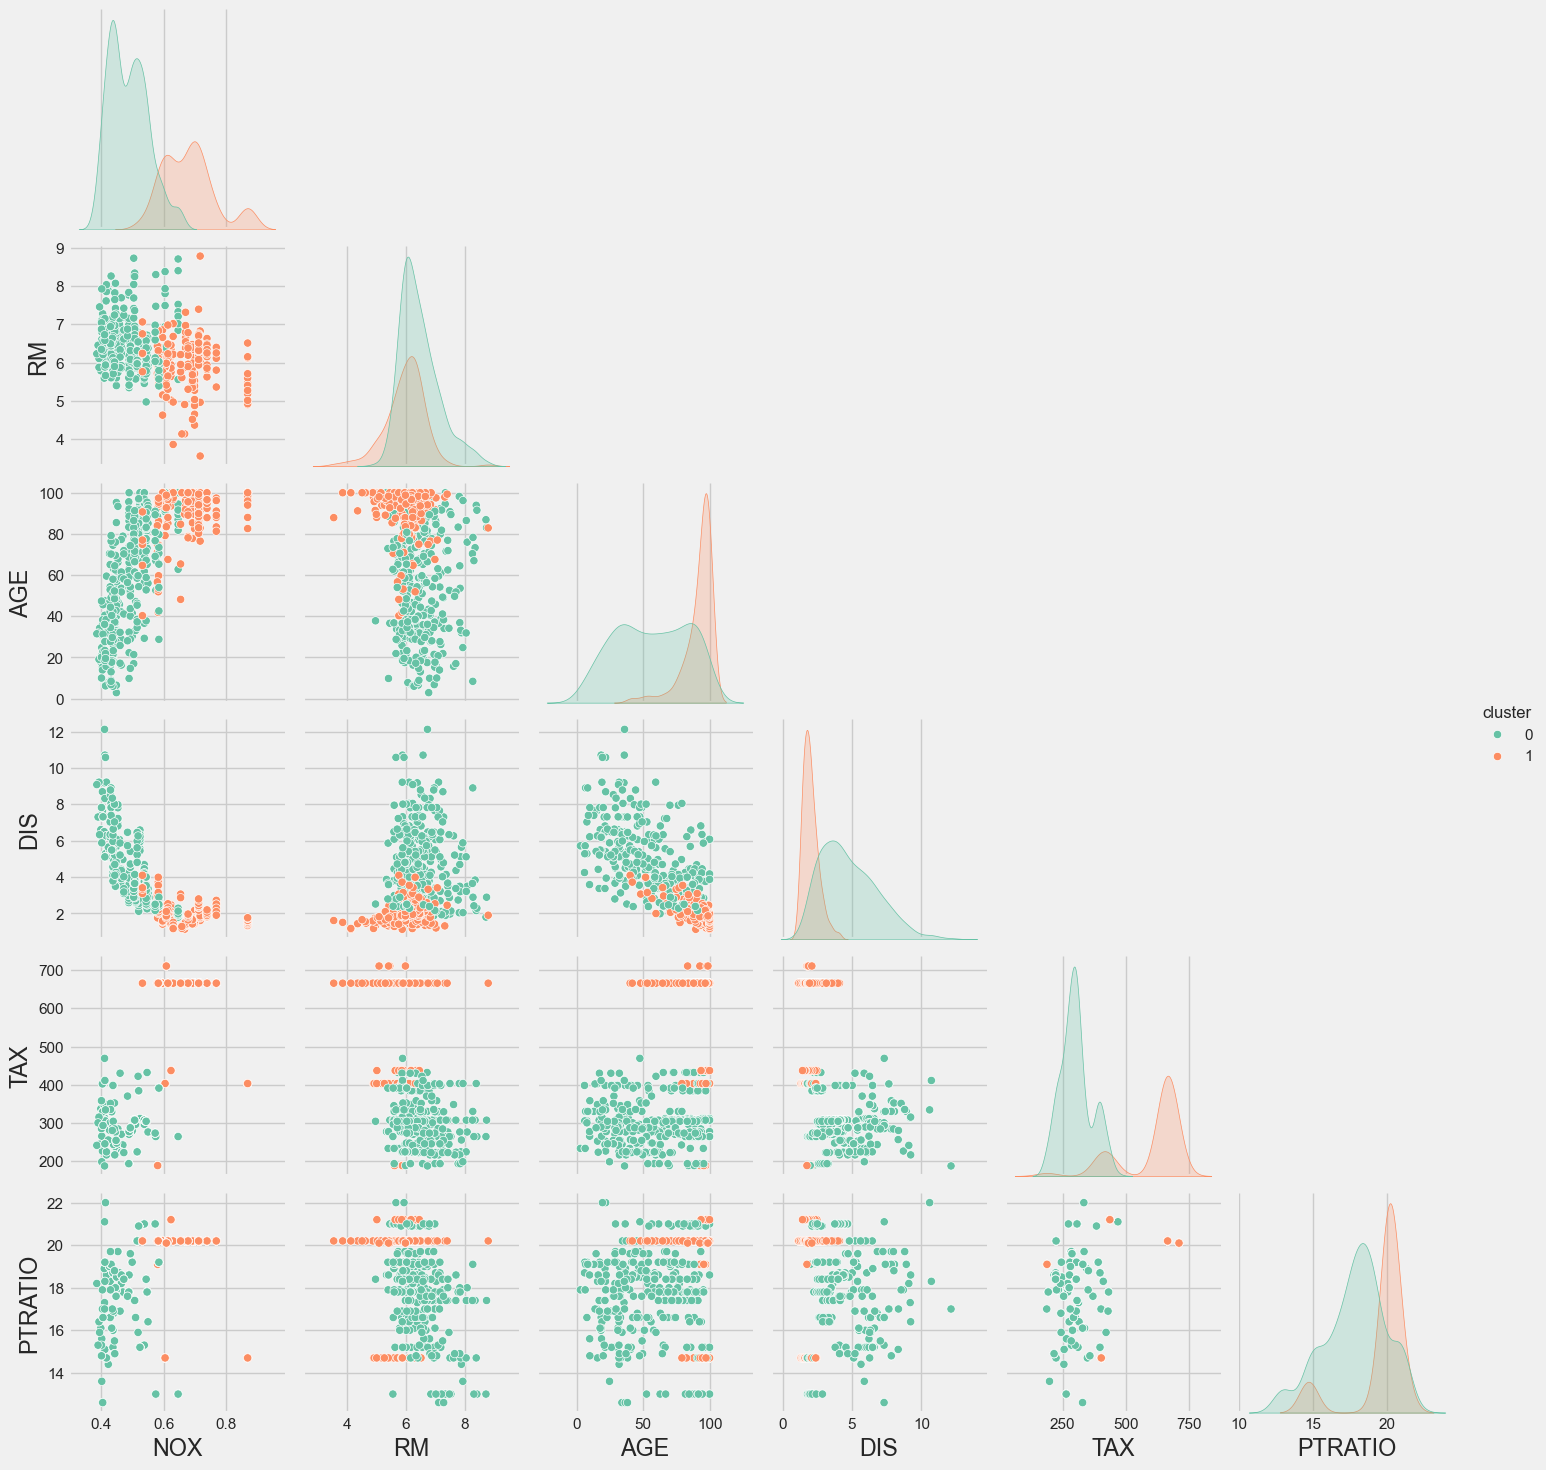

In [189]:
# 选择部分特征用于 pairplot 可视化
selected_features = ['NOX', 'RM','AGE', 'DIS','TAX','PTRATIO', 'cluster']
sns.pairplot(df[selected_features], hue='cluster', palette='Set2', diag_kind='kde', corner=True)
plt.savefig('D:/PythonProject/Pictures/boston_pairplot.png', dpi = 300)
plt.show()

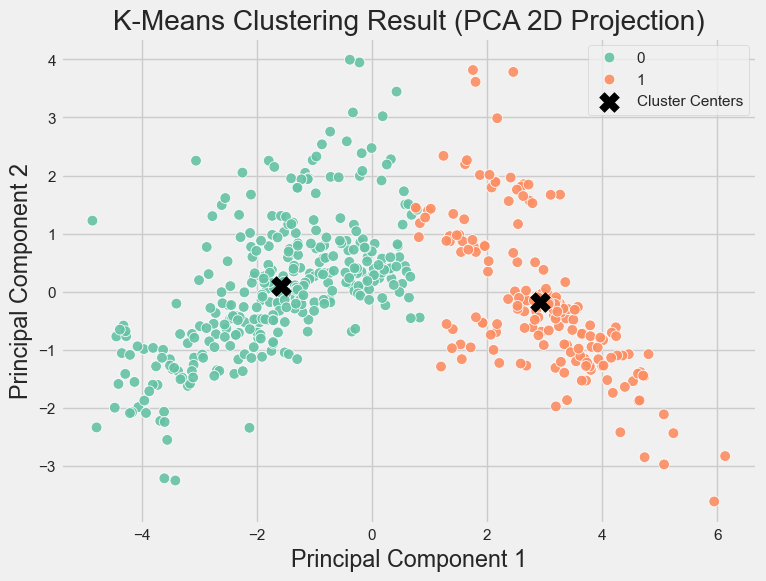

In [173]:
from sklearn.decomposition import PCA
# 对特征做 PCA 降维到 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

# 将 PCA 结果添加到 DataFrame 中
df['PCA1'] = pca_components[:, 0]
df['PCA2'] = pca_components[:, 1]

# 将聚类中心从原始特征空间投影到 PCA 空间
centers = kmeans.cluster_centers_
pca_centers = pca.transform(centers)

# 绘制数据点和聚类中心
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='cluster', palette='Set2', s=60, alpha=0.9)
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], 
            c='black', marker='X', s=200, label='Cluster Centers')
plt.title('K-Means Clustering Result (PCA 2D Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.savefig('D:/PythonProject/Pictures/boston_pca.png', dpi = 300)
plt.show()
